#**<center>Machine Learning Finance - ENSAE</center>**

 **<center>Eleonore Blanchard, Jing Tan, Yannick Ly, Inès Deguy</center>** 
 

#Importation

In [0]:
pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=a410f9e9e3e790dc2a9740de7059f56ee901ce8162f2a4705e407b6d31e789f2
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import yfinance as yf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

#Helper functions

In [0]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

class Portfolio():
    def __init__(self, initial_capital):
        self.initial_capital = initial_capital
        self.dates = []
        self.returns = []
        self.pos = [] # 0 : short/stay out from the market, 1 : buy/stay long in the market
        
    def compute_return(self, data):
        ret_benchmark = data.pct_change()[1:]
        for i in range(len(ret_benchmark)):
            self.returns.append(self.pos[i] * ret_benchmark[i])
         
    def compute_price(self):
        cum_ret = (1 + np.array(self.returns)).cumprod() - 1
        self.price = self.initial_capital * (1 + cum_ret)

def get_price(security, start_date, end_date, freq):
    return yf.download(tickers = security, start = start_date, end = end_date, interval = freq)['Adj Close']

def get_return(previous, current):
    ret = (current - previous) / previous
    if ret == -0.0:
        return 0.0
    else:
        return ret

# Function to get the state 
def get_state(pos, ret):
    return (pos, round(ret, 3))

# Function to compute the reward
def compute_reward(ret, position):
    reward = ret * position
    if reward == -0.0:
        return 0.0
    else:
        return reward

# Tabular SARSA

## SARSA Algorithm

In [0]:
class SARSA:

    # Initialize the agent with the discount and learning factors
    def __init__(self, gamma, alpha):
        self.qValues = dict()
        self.gamma = gamma
        self.alpha = alpha
        self.actions = ['buy', 'sell', 'hold'] 
        """hold : hold the previous action,
        if the previous action was buy we stay long,
        if the previous action was sell we stay out the market"""
    
    # Get the Q-value for a specific state and a specific action
    def getQValue(self, state, action):
        if (state, action) in self.qValues:
          return self.qValues[(state, action)]
        else:
          self.qValues[(state, action)] = 0.0
          return 0.0

    # Get the action that maximize the Q-value for a specific state
    def getAction(self, state):
        max_val = None
        max_action = None
        random.shuffle(self.actions)
        for action in self.actions:
          curr_val = self.getQValue(state, action)
          if max_val == None or max_val < curr_val:
            max_val = curr_val
            max_action = action
        return max_action

    # Update the values
    def update(self, state, action, nextState, nextAction, reward):
        state_val = self.getQValue(state, action)
        nextState_val = self.getQValue(nextState, nextAction)
        self.qValues[(state, action)] = state_val + self.alpha * (self.gamma * nextState_val - state_val + reward)

## SARSA training function

In [0]:
def launch_training_SARSA(data, qValues_table, training_parameters, model_parameters, context):
    
    # Initialize
    pos = list()
    pos.append(0)
    Agent = SARSA(model_parameters.alpha, model_parameters.gamma)
    Agent.qValues = qValues_table
    
    for i in range(1, len(data) - 1):
        
        # Get the return
        context.ret = get_return(data[i-1], data[i])
        
        # Update current state
        context.current_state = get_state(pos[-1], context.ret)
        
        # Explore a random action with probability epsilon (greedy-epsilon)
        epsilon = model_parameters.epsilon_parameter
        acceptance_probability = random.random()
        buy_arr = ['sell', 'hold']
        sell_arr = ['buy', 'hold']
        hold_arr = ['buy', 'sell']
        
        context.current_action = Agent.getAction(context.current_state)
        # We choose a random action to explore other action than the one that maximize the SARSA algorithm or we choose the action that maximize the SARSA algorithm
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if context.current_action == "buy":
                random.shuffle(buy_arr)
                context.current_action = buy_arr[0]
            elif context.current_action == "sell":
                random.shuffle(sell_arr)
                context.current_action = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                context.current_action = hold_arr[0]      
        
        # Update the agent
        if context.current_action == 'buy' and pos[-1] == 0:
            pos.append(1)
        elif context.current_action == 'buy' and pos[-1] == -1:
            pos.append(0)
        elif context.current_action == 'sell' and pos[-1] == 1:
            pos.append(0)
        elif context.current_action == 'sell' and pos[-1] == 0:
            pos.append(-1)
        else:
            context.current_action = 'hold'
            pos.append(pos[-1])
            
        ret_fut = get_return(data[i], data[i+1])
        state_temp = get_state(pos[-1], ret_fut)
        action_temp = Agent.getAction(state_temp)
        # We choose a random action to explore other action than the one that maximize the SARSA algorithm or we choose the action that maximize the SARSA algorithm
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if action_temp == "buy":
                random.shuffle(buy_arr)
                action_temp = buy_arr[0]
            elif action_temp == "sell":
                random.shuffle(sell_arr)
                action_temp = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                action_temp = hold_arr[0]
        reward = compute_reward(ret_fut, pos[-1])
        Agent.update(
            context.current_state, 
            context.current_action, 
            state_temp, 
            action_temp,
            reward
            )
        
        # Update the previous and current states
        context.previous_action = context.current_action
        
        # Count the number of occurence of a state
        if context.current_state in context.state_counter_dict:
            context.state_counter_dict[context.current_state] += 1
        else:
            context.state_counter_dict[context.current_state] = 0
            
        # Count the number of occurence of a action
        context.action_counter_dict[context.current_action] += 1
            
    return Agent.qValues

## SARSA backtesting function

In [0]:
def launch_backtest_SARSA(data, P, qValues_opt, backtest_parameters, model_parameters, context):
    
    ### Initialize
    P.dates = data.index
    P.pos.append(0) # because we suppose that we have only cash in the portfolio at the beginning
    Agent = SARSA(model_parameters.alpha, model_parameters.gamma)
    Agent.qValues = qValues_opt
    
    for i in range(1, len(data)):
        
        # Get the return
        context.ret = get_return(data[i-1], data[i])
        
        # Update current state
        context.current_state = get_state(P.pos[-1], context.ret) # state = (pos, round(log(ret)), 3)
        
        # Explore a random action with probability epsilon (greedy-epsilon)
        epsilon = model_parameters.epsilon_parameter
        acceptance_probability = random.random()
        buy_arr = ['sell', 'hold']
        sell_arr = ['buy', 'hold']
        hold_arr = ['buy', 'sell']
        
        context.current_action = Agent.getAction(context.current_state)
        # We choose a random action to explore other action than the one that maximize the SARSA algorithm or or we choose the action that maximize the SARSA algorithm
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if context.current_action == "buy":
                random.shuffle(buy_arr)
                context.current_action = buy_arr[0]
            elif context.current_action == "sell":
                random.shuffle(sell_arr)
                context.current_action = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                context.current_action = hold_arr[0]
            
        # Update the agent
        if context.current_action == 'buy' and P.pos[-1] == 0:
            P.pos.append(1)
        elif context.current_action == 'buy' and P.pos[-1] == -1:
            P.pos.append(0)
        elif context.current_action == 'sell' and P.pos[-1] == 1:
            P.pos.append(0)
        elif context.current_action == 'sell' and P.pos[-1] == 0:
            P.pos.append(-1)
        else:
            context.current_action = 'hold'
            P.pos.append(P.pos[-1])
            
        state_temp = get_state(P.pos[-1], context.ret)
        action_temp = Agent.getAction(state_temp)
        # We choose a random action to explore other action than the one that maximize the SARSA algorithm or we choose the action that maximize the SARSA algorithm
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if action_temp == "buy":
                random.shuffle(buy_arr)
                action_temp = buy_arr[0]
            elif action_temp == "sell":
                random.shuffle(sell_arr)
                action_temp = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                action_temp = hold_arr[0]
        
        reward = compute_reward(context.ret, P.pos[-1])
        Agent.update(
            context.current_state, 
            context.current_action, 
            state_temp, 
            action_temp,
            reward
            )
            
        # Update the previous and current states
        context.previous_action = context.current_action
            
        # Count the number of occurence of a state
        if context.current_state in context.state_counter_dict:
            context.state_counter_dict[context.current_state] += 1
        else:
            context.state_counter_dict[context.current_state] = 0
                
        # Count the number of occurence of a action
        context.action_counter_dict[context.current_action] += 1

# Tabular Q-Learning

## Q-Learning Algorithm

In [0]:
class QLearner:

    # Initialize the agent with the discount and learning factors
    def __init__(self, gamma, alpha):
        self.qValues = dict()
        self.gamma = gamma
        self.alpha = alpha
        self.actions = ['buy', 'sell', 'hold'] 
        """hold : hold the previous action,
        if the previous action was buy we stay long,
        if the previous action was sell we stay out the market"""
    
    # Get the Q-value for a specific state and a specific action
    def getQValue(self, state, action):
        if (state, action) in self.qValues:
          return self.qValues[(state, action)]
        else:
          self.qValues[(state, action)] = 0.0
          return 0.0
      
    # Get the action's Q-value that maximize a specific state
    def computeValueFromQValues(self, state):
        actions = self.actions
        max_val = max([self.getQValue(state, action) for action in actions])
        return max_val

    # Get the action that maximize the Q-value for a specific state
    def getAction(self, state):
        max_val = None
        max_action = None
        random.shuffle(self.actions)
        for action in self.actions:
          curr_val = self.getQValue(state, action)
          if max_val == None or max_val < curr_val:
            max_val = curr_val
            max_action = action
        return max_action

    # Update the values
    def update(self, state, action, nextState, reward):
        state_val = self.getQValue(state, action)
        nextState_val = self.computeValueFromQValues(nextState)
        self.qValues[(state, action)] = state_val + self.alpha * (self.gamma * nextState_val - state_val + reward)

## Q-Learning training function

In [0]:
def launch_training_Q(data, qValues_table, training_parameters, model_parameters, context):
    
    # Initialize
    pos = list()
    pos.append(0)
    Agent = QLearner(model_parameters.alpha, model_parameters.gamma)
    Agent.qValues = qValues_table
    
    for i in range(1, len(data) - 1):
        
        # Get the return
        context.ret = get_return(data[i-1], data[i])
        
        # Update current state
        context.current_state = get_state(pos[-1], context.ret)
        
        # Explore a random action with probability epsilon (greedy-epsilon)
        epsilon = model_parameters.epsilon_parameter
        acceptance_probability = random.random()
        buy_arr = ['sell', 'hold']
        sell_arr = ['buy', 'hold']
        hold_arr = ['buy', 'sell']
        
        context.current_action = Agent.getAction(context.current_state)
        # We choose a random action to explore other action than the one that maximize the SARSA algorithm or we choose the action that maximize the SARSA algorithm
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if context.current_action == "buy":
                random.shuffle(buy_arr)
                context.current_action = buy_arr[0]
            elif context.current_action == "sell":
                random.shuffle(sell_arr)
                context.current_action = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                context.current_action = hold_arr[0]
        
        # Update the agent
        if context.current_action == 'buy' and pos[-1] == 0:
            pos.append(1)
        elif context.current_action == 'buy' and pos[-1] == -1:
            pos.append(0)
        elif context.current_action == 'sell' and pos[-1] == 1:
            pos.append(0)
        elif context.current_action == 'sell' and pos[-1] == 0:
            pos.append(-1)
        else:
            context.current_action = 'hold'
            pos.append(pos[-1])
        
        ret_fut = get_return(data[i], data[i+1])
        state_temp = get_state(pos[-1], ret_fut)
        reward = compute_reward(ret_fut, pos[-1])
        Agent.update(
            context.current_state, 
            context.current_action, 
            state_temp, 
            reward
            )
        
        # Update the previous action
        context.previous_action = context.current_action
        
        # Count the number of occurence of a state
        if context.current_state in context.state_counter_dict:
            context.state_counter_dict[context.current_state] += 1
        else:
            context.state_counter_dict[context.current_state] = 0
            
        # Count the number of occurence of a action
        context.action_counter_dict[context.current_action] += 1
            
    return Agent.qValues

## Q-Learning backtesting function

In [0]:
def launch_backtest_Q(data, P, qValues_opt, backtest_parameters, model_parameters, context):
    
    P.dates = data.index
    P.pos.append(0) # because we suppose that we have only cash in the portfolio at the beginning
    Agent = QLearner(model_parameters.alpha, model_parameters.gamma)
    Agent.qValues = qValues_opt
    
    for i in range(1, len(data)):
        
        # Get the return
        context.ret = get_return(data[i-1], data[i])
        
        # Update current state
        context.current_state = get_state(P.pos[-1], context.ret)
        
        # Explore a random action with probability epsilon (greedy-epsilon)
        epsilon = model_parameters.epsilon_parameter
        acceptance_probability = random.random()
        buy_arr = ['sell', 'hold']
        sell_arr = ['buy', 'hold']
        hold_arr = ['buy', 'sell']
        
        context.current_action = Agent.getAction(context.current_state)
        # We choose a random action to explore other action than the one that maximize the SARSA algorithm or or we choose the action that maximize the SARSA algorithm
        if acceptance_probability < epsilon:
            context.random_counter += 1
            if context.current_action == "buy":
                random.shuffle(buy_arr)
                context.current_action = buy_arr[0]
            elif context.current_action == "sell":
                random.shuffle(sell_arr)
                context.current_action = sell_arr[0]
            else:
                random.shuffle(hold_arr)
                context.current_action = hold_arr[0]
        
        # Update the agent
        if context.current_action == 'buy' and P.pos[-1] == 0:
            P.pos.append(1)
        elif context.current_action == 'buy' and P.pos[-1] == -1:
            P.pos.append(0)
        elif context.current_action == 'sell' and P.pos[-1] == 1:
            P.pos.append(0)
        elif context.current_action == 'sell' and P.pos[-1] == 0:
            P.pos.append(-1)
        else:
            context.current_action = 'hold'
            P.pos.append(P.pos[-1])
            
        state_temp = get_state(P.pos[-1], context.ret)
        reward = compute_reward(context.ret, P.pos[-1])
        Agent.update(
            context.current_state, 
            context.current_action, 
            state_temp, 
            reward
            )
        
        # Update the previous action
        context.previous_action = context.current_action
        
        # Count the number of occurence of a state
        if context.current_state in context.state_counter_dict:
            context.state_counter_dict[context.current_state] += 1
        else:
            context.state_counter_dict[context.current_state] = 0
            
        # Count the number of occurence of a action
        context.action_counter_dict[context.current_action] += 1

# Training

## Training SARSA

In [0]:
model_parameters = AttrDict() # Model parameters
args_dict = {
        'alpha' : 0.3, # learning coefficient
        'gamma' : 0.9, # gamma coefficient
        'epsilon_parameter' : 0.1, # randomizing parameter
        }
model_parameters.update(args_dict)

training_parameters = AttrDict() # Training parameters
args_dict = {
        'security' : '^GSPC', 
        'start_date' : None,
        'end_date' : '2018-12-31',
        'frequency' : '1d',
        'epoch' : 50
        }
training_parameters.update(args_dict)

data = get_price(training_parameters.security, training_parameters.start_date, training_parameters.end_date, training_parameters.frequency)
qValues_table = dict()
for _ in range(training_parameters.epoch):
    
    context = AttrDict() # context variables
    args_dict = {
            'ret' : 0,
            'current_state' : None,
            'previous_action' : 'hold', # we suppose the first action is stay out of the market
            'current_action' : None, 
            'state_counter_dict' : dict(),
            'action_counter_dict' : dict({'buy' : 0, 'sell' : 0, 'hold' : 0}),
            'random_counter' : 0
            }
    context.update(args_dict)
    
    qValues_table = launch_training_SARSA(data, qValues_table, training_parameters, model_parameters, context)
    sys.stdout.write(
            "\r[Epoch %d/%d]"
            % (
                _,
                training_parameters.epoch)
            )

qValues_opt_SARSA = qValues_table

[*********************100%***********************]  1 of 1 completed
[Epoch 49/50]

## Training Q-Learning

In [0]:
model_parameters = AttrDict() # Model parameters
args_dict = {
        'alpha' : 0.3, # learning coefficient
        'gamma' : 0.9, # gamma coefficient
        'epsilon_parameter' : 0.1, # randomizing parameter
        }
model_parameters.update(args_dict)

training_parameters = AttrDict() # Training parameters
args_dict = {
        'security' : '^GSPC', 
        'start_date' : None,
        'end_date' : '2018-12-31',
        'frequency' : '1d',
        'epoch' : 50
        }
training_parameters.update(args_dict)

data = get_price(training_parameters.security, training_parameters.start_date, training_parameters.end_date, training_parameters.frequency)
qValues_table = dict()
for _ in range(training_parameters.epoch):
    
    context = AttrDict() # context variables
    args_dict = {
            'ret' : 0,
            'current_state' : None,
            'previous_action' : 'hold', # we suppose the first action is stay out of the market
            'current_action' : None,
            'state_counter_dict' : dict(),
            'action_counter_dict' : dict({'buy' : 0, 'sell' : 0, 'hold' : 0}),
            'random_counter' : 0
            }
    context.update(args_dict)
    
    qValues_table = launch_training_Q(data, qValues_table, training_parameters, model_parameters, context)
    sys.stdout.write(
            "\r[Epoch %d/%d]"
            % (
                _,
                training_parameters.epoch)
            )

qValues_opt_Q = qValues_table

[*********************100%***********************]  1 of 1 completed
[Epoch 49/50]

# Backtesting

## Backtesting SARSA

In [0]:
model_parameters = AttrDict() # Model parameters
args_dict = {
        'alpha' : 0.3, # learning coefficient
        'gamma' : 0.9, # gamma coefficient
        'epsilon_parameter' : 0.01, # randomizing parameter
        }
model_parameters.update(args_dict)
    
backtest_parameters = AttrDict() # Back test parameters
args_dict = {
        'security' : '^GSPC', 
        'start_date' : '2019-01-01', # format yyyy-mm-dd
        'end_date' : '2020-01-01', # format yyyy-mm-dd
        'frequency' : '1d', # daily
        'initial_capital' : 1000, # initial capital for the backtest
        }
backtest_parameters.update(args_dict)
    
context = AttrDict() # context variables
args_dict = {
        'ret' : 0,
        'current_state' : None, 
        'previous_action' : 'hold', # we suppose the first action is stay out of the market
        'current_action' : None,
        'state_counter_dict' : dict(),
        'action_counter_dict' : dict({'buy' : 0, 'sell' : 0, 'hold' : 0}),
        'random_counter' : 0
        }
context.update(args_dict)

data = get_price(backtest_parameters.security, backtest_parameters.start_date, backtest_parameters.end_date, backtest_parameters.frequency)
P_SARSA = Portfolio(initial_capital = backtest_parameters.initial_capital)
launch_backtest_SARSA(data, P_SARSA, qValues_opt_SARSA, backtest_parameters, model_parameters, context)
P_SARSA.compute_return(data)
P_SARSA.compute_price()

[*********************100%***********************]  1 of 1 completed


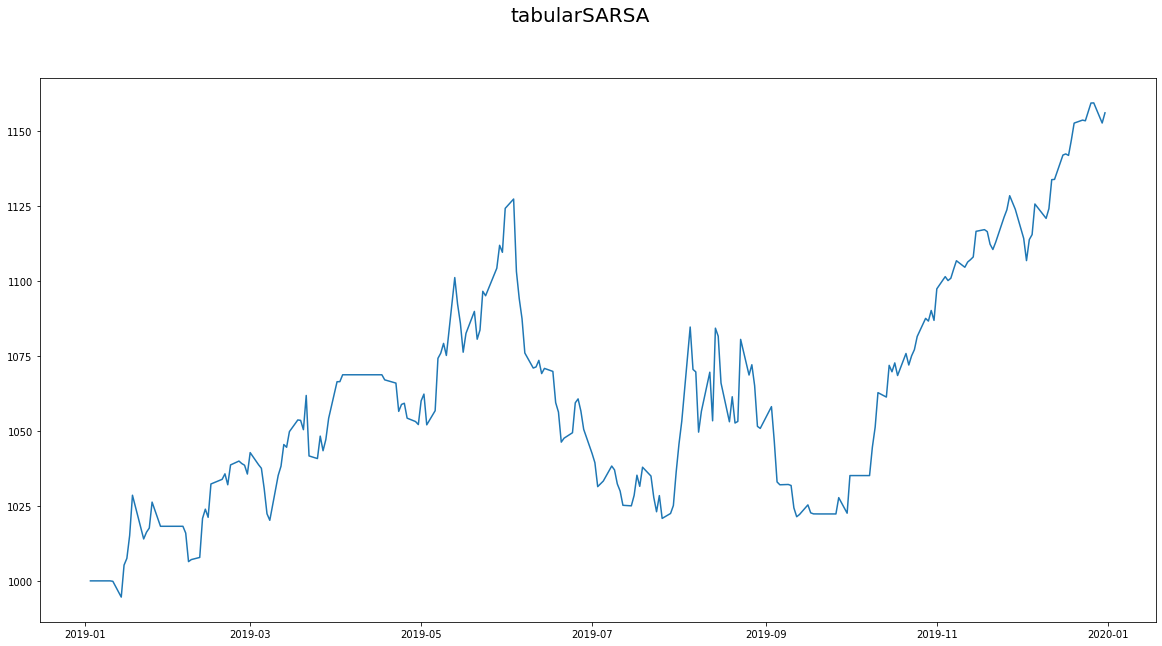

In [0]:
# Performance of the SARSA portfolio

fig = plt.figure(figsize=(20,10))
fig.suptitle('tabularSARSA', fontsize = 20)
plt.plot(P_SARSA.dates[1:], P_SARSA.price)

In [0]:
# Comparison with the benchmark

benchmark = get_price(backtest_parameters.security, backtest_parameters.start_date, backtest_parameters.end_date, backtest_parameters.frequency)

ret_benchmark = pd.DataFrame(benchmark).pct_change()[1:]
ret_ptf = pd.DataFrame(P_SARSA.price).pct_change()[1:]

ret_annualized_benchmark = np.mean(ret_benchmark)*252
ret_annualized_ptf = np.mean(ret_ptf)*252

vol_annualized_benchmark = np.std(ret_benchmark) * np.sqrt(252)
vol_annualized_ptf = np.std(ret_ptf) * np.sqrt(252)

sharpe_ratio_benchmark = ret_annualized_benchmark / vol_annualized_benchmark
sharpe_ratio_ptf = ret_annualized_ptf / vol_annualized_ptf

result = pd.DataFrame(data = [[ret_annualized_benchmark[0], ret_annualized_ptf[0]], 
                              [vol_annualized_benchmark[0], vol_annualized_ptf[0]],
                              [sharpe_ratio_benchmark[0], sharpe_ratio_ptf[0]]],
                     columns = ['Benchmark', 'Portfolio SARSA'],
                     index = ['Ret annualized', 'Vol annualized', 'Sharpe Ratio'])
print(result)

[*********************100%***********************]  1 of 1 completed
                Benchmark  Portfolio SARSA
Ret annualized   0.261357         0.152215
Vol annualized   0.124720         0.110899
Sharpe Ratio     2.095539         1.372557


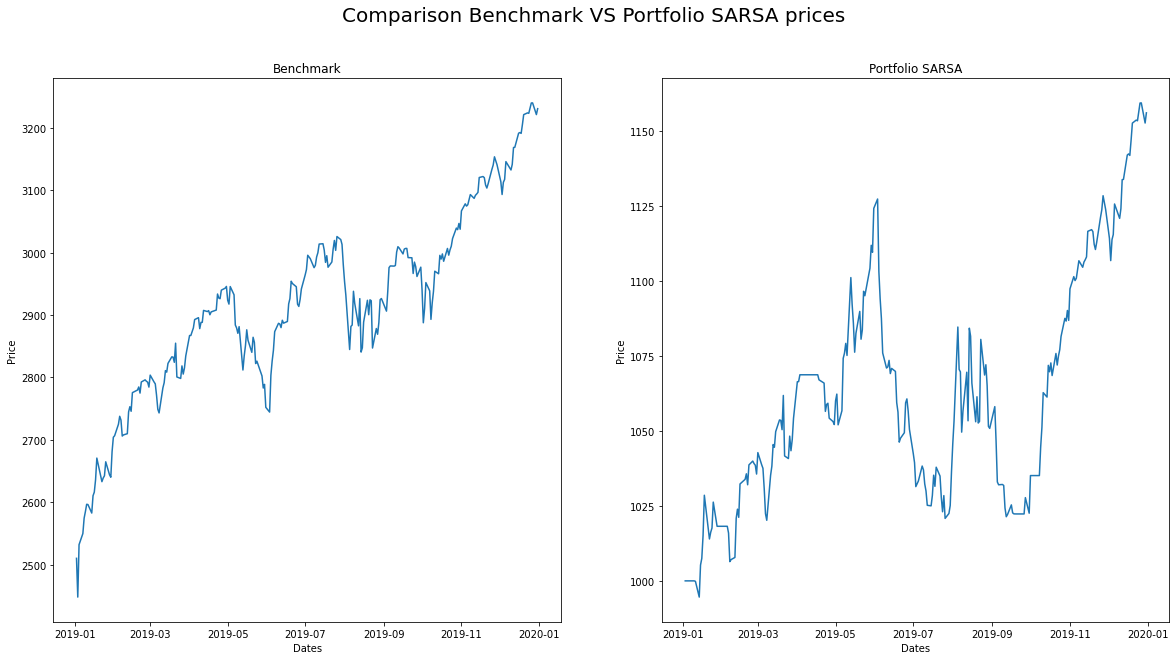

In [0]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Comparison Benchmark VS Portfolio SARSA prices', fontsize = 20)
ax1 = plt.subplot(121)
ax1.title.set_text('Benchmark')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Price')
plt.plot(benchmark.index, benchmark)
ax2 = plt.subplot(122)
ax2.title.set_text('Portfolio SARSA')
ax2.set_xlabel('Dates')
ax2.set_ylabel('Price')
plt.plot(P_SARSA.dates[1:], P_SARSA.price)

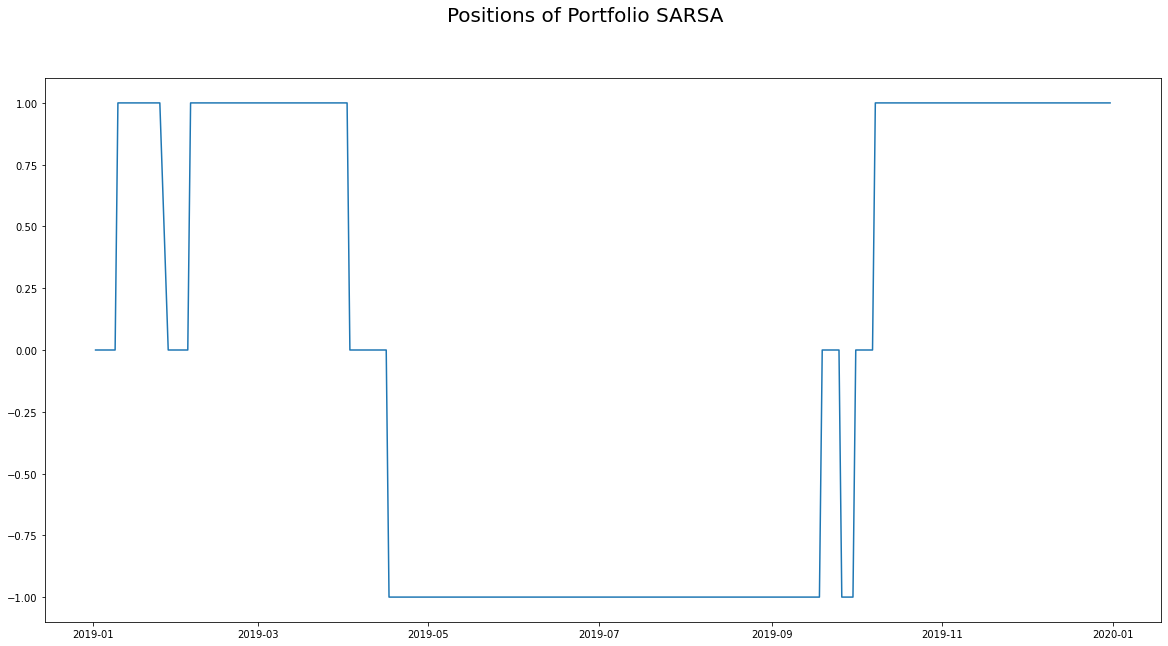

In [0]:
# Positions

fig = plt.figure(figsize=(20,10))
fig.suptitle('Positions of Portfolio SARSA', fontsize = 20)
plt.plot(P_SARSA.dates, P_SARSA.pos)

## Backtesting Q-Learning

In [0]:
model_parameters = AttrDict() # Model parameters
args_dict = {
        'alpha' : 0.2, # learning coefficient
        'gamma' : 0.9, # gamma coefficient
        'epsilon_parameter' : 0.01, # randomizing parameter
        }
model_parameters.update(args_dict)
    
backtest_parameters = AttrDict() # Back test parameters
args_dict = {
        'security' : '^GSPC', 
        'start_date' : '2019-01-01', # format yyyy-mm-dd
        'end_date' : '2020-01-01', # format yyyy-mm-dd
        'frequency' : '1d', # daily
        'initial_capital' : 1000, # initial capital for the backtest
        }
backtest_parameters.update(args_dict)
    
context = AttrDict() # context variables
args_dict = {
        'ret' : 0,
        'current_state' : None,
        'previous_action' : 'hold', # we suppose the first action is stay out of the market
        'current_action' : None,
        'state_counter_dict' : dict(),
        'action_counter_dict' : dict({'buy' : 0, 'sell' : 0, 'hold' : 0}),
        'random_counter' : 0
        }
context.update(args_dict)
    
data = get_price(backtest_parameters.security, backtest_parameters.start_date, backtest_parameters.end_date, backtest_parameters.frequency)
P_Q = Portfolio(initial_capital = backtest_parameters.initial_capital)
launch_backtest_Q(data, P_Q, qValues_opt_Q, backtest_parameters, model_parameters, context)
P_Q.compute_return(data)
P_Q.compute_price()

[*********************100%***********************]  1 of 1 completed


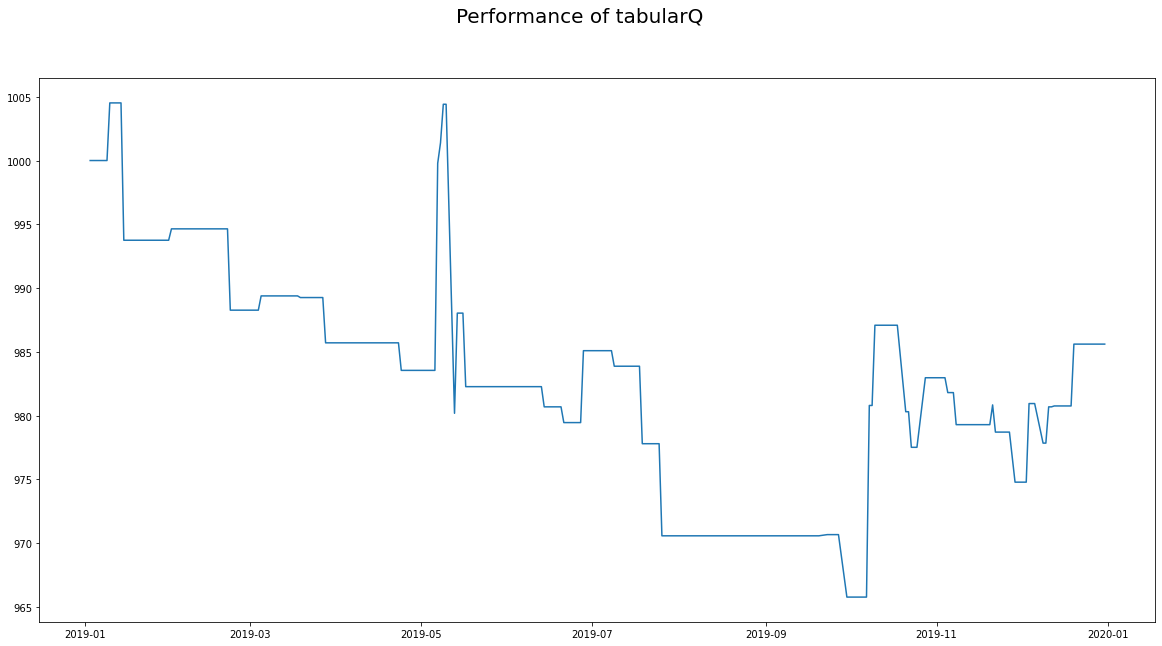

In [0]:
# Performance of the Q-Learning portfolio

fig = plt.figure(figsize=(20,10))
fig.suptitle('Performance of tabularQ', fontsize = 20)
plt.plot(P_Q.dates[1:], P_Q.price)

In [0]:
# Comparison with the benchmark

benchmark = get_price(backtest_parameters.security, backtest_parameters.start_date, backtest_parameters.end_date, backtest_parameters.frequency)

ret_benchmark = pd.DataFrame(benchmark).pct_change()[1:]
ret_ptf = pd.DataFrame(P_Q.price).pct_change()[1:]

ret_annualized_benchmark = np.mean(ret_benchmark)*252
ret_annualized_ptf = np.mean(ret_ptf)*252

vol_annualized_benchmark = np.std(ret_benchmark) * np.sqrt(252)
vol_annualized_ptf = np.std(ret_ptf) * np.sqrt(252)

sharpe_ratio_benchmark = ret_annualized_benchmark / vol_annualized_benchmark
sharpe_ratio_ptf = ret_annualized_ptf / vol_annualized_ptf

result = pd.DataFrame(data = [[ret_annualized_benchmark[0], ret_annualized_ptf[0]], 
                              [vol_annualized_benchmark[0], vol_annualized_ptf[0]],
                              [sharpe_ratio_benchmark[0], sharpe_ratio_ptf[0]]],
                     columns = ['Benchmark', 'Portfolio Q'],
                     index = ['Ret annualized', 'Vol annualized', 'Sharpe Ratio'])
print(result)

[*********************100%***********************]  1 of 1 completed
                Benchmark  Portfolio Q
Ret annualized   0.261357    -0.013708
Vol annualized   0.124720     0.042614
Sharpe Ratio     2.095539    -0.321671


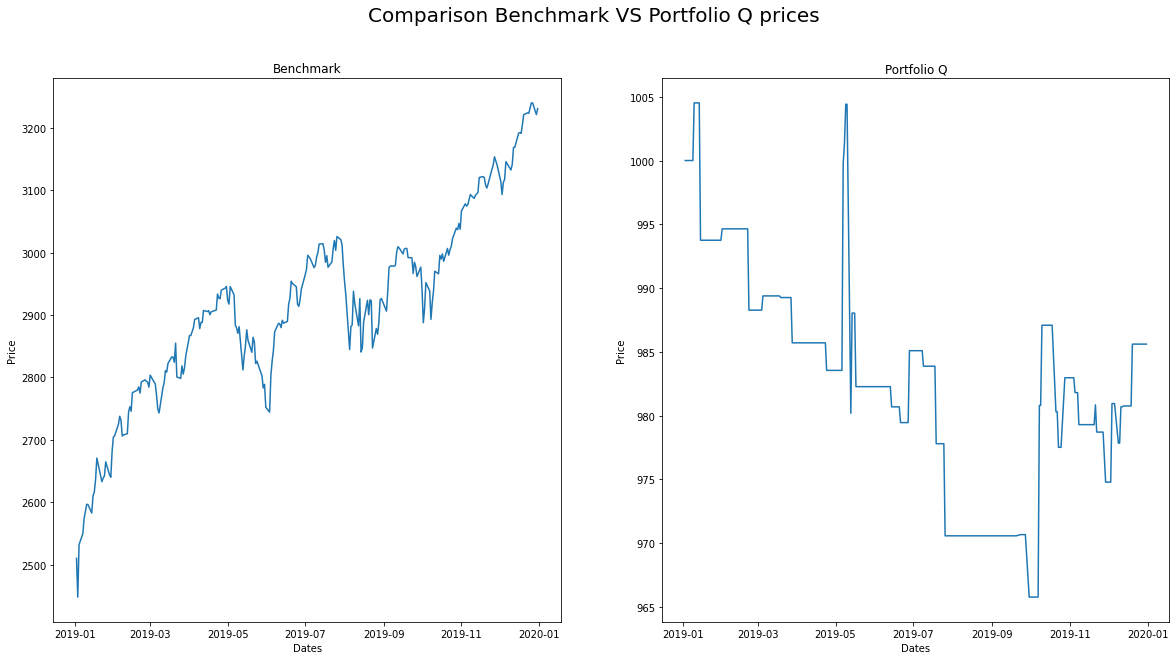

In [0]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Comparison Benchmark VS Portfolio Q prices', fontsize = 20)
ax1 = plt.subplot(121)
ax1.title.set_text('Benchmark')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Price')
plt.plot(benchmark.index, benchmark)
ax2 = plt.subplot(122)
ax2.title.set_text('Portfolio Q')
ax2.set_xlabel('Dates')
ax2.set_ylabel('Price')
plt.plot(P_Q.dates[1:], P_Q.price)

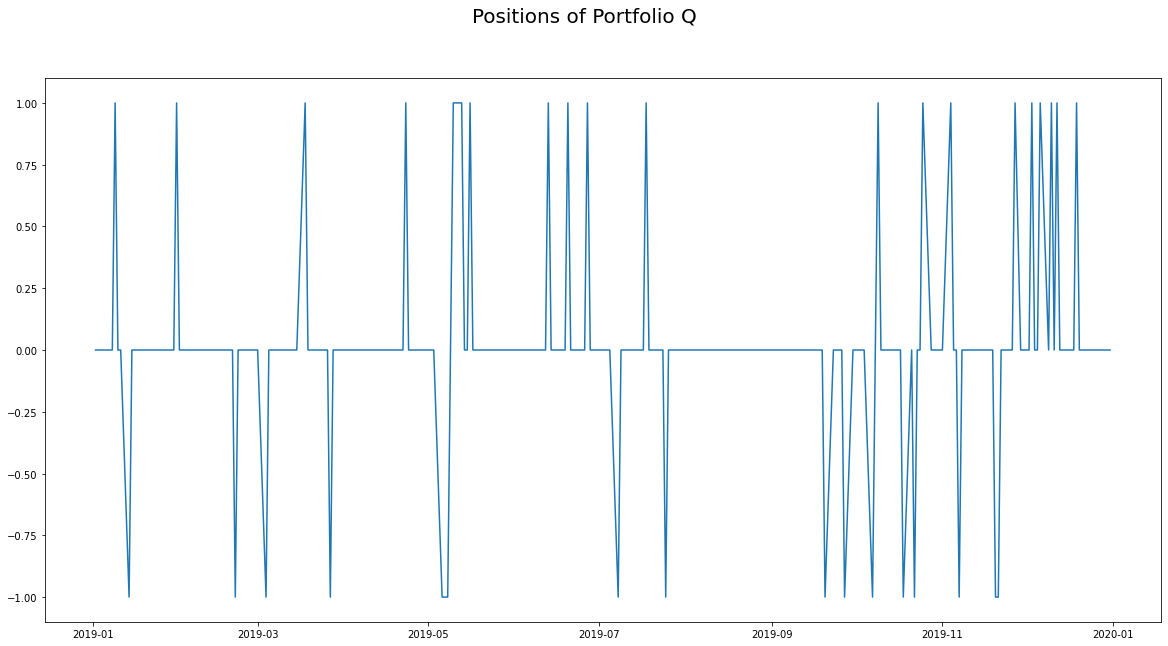

In [0]:
# Positions

fig = plt.figure(figsize=(20,10))
fig.suptitle('Positions of Portfolio Q', fontsize = 20)
plt.plot(P_Q.dates, P_Q.pos)